In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
from tqdm import tqdm
import tensorflow as tf

In [32]:
#defining train data set
train_dir='aks/data'
Train_Data=tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=64,subset="training",target_size=(152,152),shuffle=False)


Found 385 images belonging to 2 classes.


In [33]:
list(Train_Data.class_indices.keys())

['ahmed_khairullah', 'ahmed_khaled']

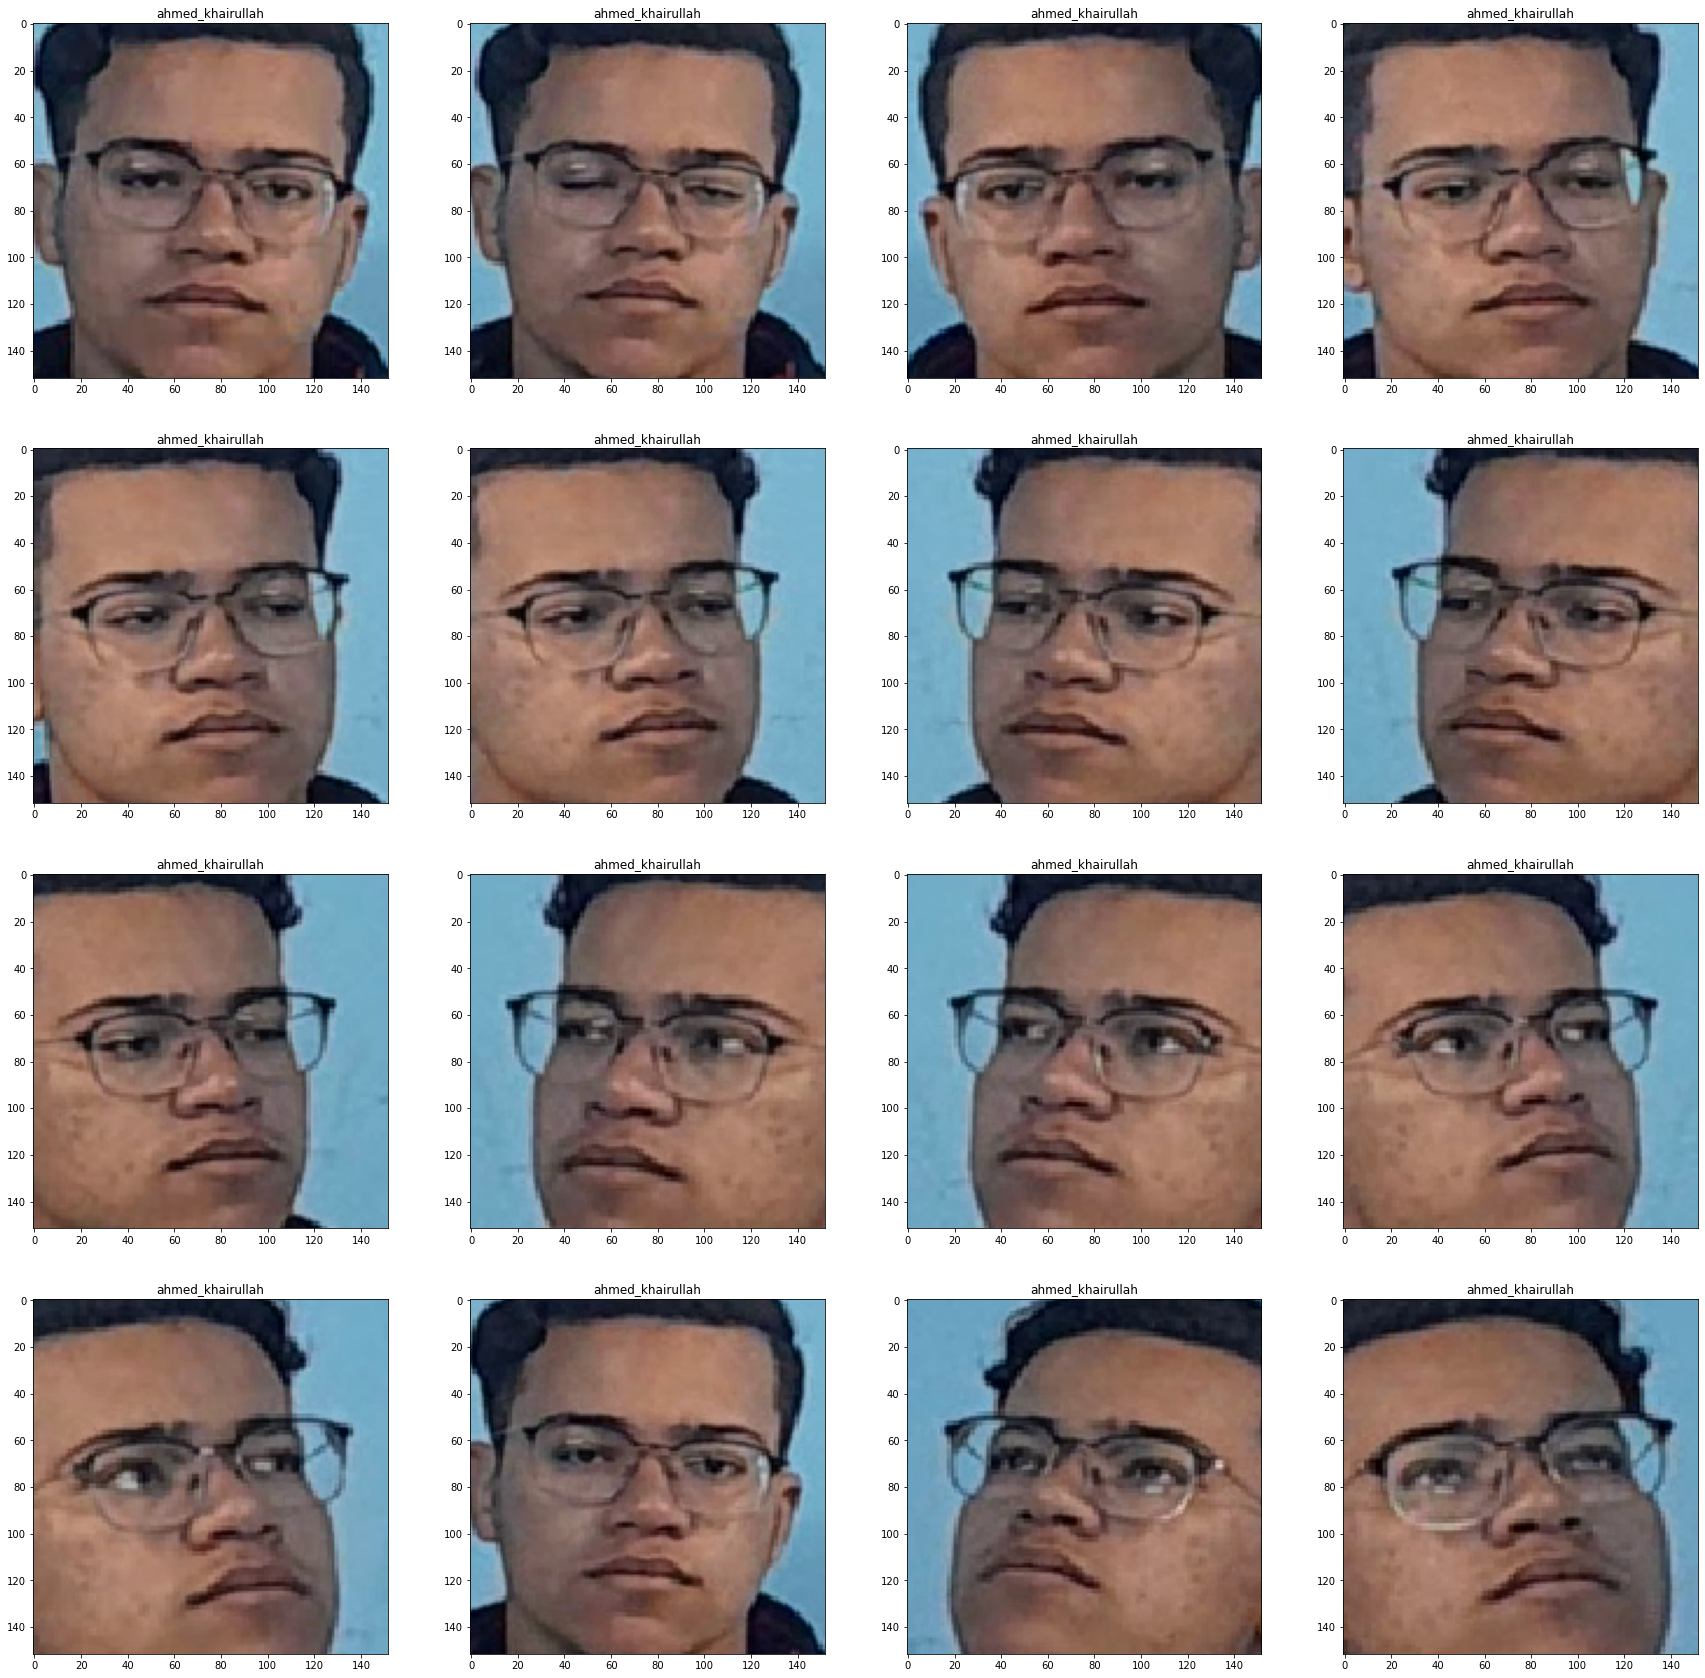

In [34]:
classes=list(Train_Data.class_indices.keys())
plt.figure(figsize=(30,30))
for X_batch, y_batch in Train_Data:
    # create a grid of 7x7 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [35]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import  Convolution2D, LocallyConnected2D, MaxPooling2D, Flatten, Dense, Dropout


#DeepFace model
base_model = Sequential()
base_model.add(Convolution2D(32, (11, 11), activation='relu', name='C1', input_shape=(152, 152, 3)))
base_model.add(MaxPooling2D(pool_size=3, strides=2, padding='same', name='M2'))
base_model.add(Convolution2D(16, (9, 9), activation='relu', name='C3'))
base_model.add(LocallyConnected2D(16, (9, 9), activation='relu', name='L4'))
base_model.add(LocallyConnected2D(16, (7, 7), strides=2, activation='relu', name='L5') )
base_model.add(LocallyConnected2D(16, (5, 5), activation='relu', name='L6'))
base_model.add(Flatten(name='F0'))
base_model.add(Dense(4096, activation='relu', name='F7'))
base_model.add(Dropout(rate=0.5, name='D0'))
base_model.add(Dense(8631, activation='softmax', name='F8'))

base_model.load_weights("VGGFace2_DeepFace_weights_val-0.9034.h5")

#Drop F8 and D0 layers. F7 is the representation layer.
model = Model(inputs=base_model.layers[0].input, outputs=base_model.layers[-3].output)



In [36]:
embedding_vector = model.predict(Train_Data,steps=len(Train_Data), verbose=1)

7/7 [==============================] - 31s 4s/step


In [37]:
np.save('Xdfdata',embedding_vector)

In [38]:
y_train=Train_Data.labels

In [39]:
np.save('ydfdata',y_train)

In [40]:
embedding_vector = np.load('Xdfdata.npy')
y_train = np.load('ydfdata.npy')

In [41]:
embedding_vector[0]

array([0.       , 0.       , 0.       , ..., 0.       , 3.922624 ,
       3.8322434], dtype=float32)

In [42]:
y_train[0]

0

In [43]:
from sklearn.utils import shuffle
X_train,y_train = shuffle(embedding_vector,y_train)

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.1,shuffle=True, stratify=y_train,random_state=42)

In [45]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [47]:
X_train.shape

(346, 128)

In [48]:
from sklearn.svm import SVC

clf = SVC(kernel='linear',C=2.,class_weight='balanced',decision_function_shape='ovo',probability=True)
clf.fit(X_train, y_train)

SVC(C=2.0, class_weight='balanced', decision_function_shape='ovo',
    kernel='linear', probability=True)

In [49]:
y_predict = clf.predict(X_test)

In [50]:
y_predict[:5]

array([1, 1, 0, 1, 1])

In [51]:
# Find the classification accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_predict)

0.9743589743589743

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.97        20

    accuracy                           0.97        39
   macro avg       0.97      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



In [53]:
from numpy import expand_dims
from cv2 import resize,INTER_CUBIC
from tensorflow.keras.preprocessing.image import  img_to_array

def preprocess_image(img):
    img = img_to_array(img)
    img = img/255.0
    img = expand_dims(img, axis=0)
    return img

def Face_Recognition(roi,model,scaler,pca,clf):
    roi=resize(roi,dsize=(152,152),interpolation=INTER_CUBIC)
    roi=preprocess_image(roi)
    embedding_vector = model.predict(roi)[0]

    embedding_vector=scaler.transform(embedding_vector.reshape(1, -1))
    embedding_vector_pca = pca.transform(embedding_vector)
    result1 = clf.predict(embedding_vector_pca)[0]
    #print(result1)
    y_predict = clf.predict_proba(embedding_vector_pca)[0]
    #print(y_predict)
    
    result = np.where(y_predict > 0.6)[0]
    
    return result

In [54]:
print((list(Train_Data.class_indices.keys())))

['ahmed_khairullah', 'ahmed_khaled']


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mtcnn.mtcnn import MTCNN
detector=MTCNN()
cap=cv2.VideoCapture('20221126_163951.mp4')
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 500)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 600)
classes = {'ahmed_khairullah': 0, 'ahmed_khaled': 1}


def ImageClass(n):
    for x , y in classes.items():
        if n == y :
            return x
size = (1600, 1200)

result_video = cv2.VideoWriter('Output Test Face 1.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
font = cv2.FONT_HERSHEY_SIMPLEX     
fontScale = 1
color = (255, 0, 0)
thickness = 2
other = 0
while True :
    ret, frame = cap.read()
    if not ret:
        break  
    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    frame=cv2.resize(frame,(1600,1200),interpolation=cv2.INTER_CUBIC)
    frame=cv2.GaussianBlur(frame, ksize=(3,3), sigmaX=0)
    detections=detector.detect_faces(frame)

    for det in detections:
        if det['confidence'] >= 0.9:
            x, y, w, h = det['box']
            roi=frame[y:y+h,x:x+w]
            roi = cv2.resize(roi,(152,152),interpolation=cv2.INTER_CUBIC)
            result=Face_Recognition(roi,model,scaler,pca,clf)
            if len(result) > 1 :
                cv2.putText(frame, ImageClass(result[0]) , (x-5,y-5), font,fontScale, color, thickness, cv2.LINE_AA)
            elif  len(result)== 0 :
                roi=cv2.cvtColor(roi,cv2.COLOR_RGB2BGR)  
                cv2.imwrite(f'Pic{other}.png', roi)
                cv2.putText(frame, 'Other' , (x-5,y-5), font,fontScale, color, thickness, cv2.LINE_AA)
                other = other + 1
            else :
                cv2.putText(frame, ImageClass(result) , (x-5,y-5), font,fontScale, color, thickness, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    frame=cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)             
    result_video.write(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
result_video.release()
cv2.destroyAllWindows() 

In [32]:
from joblib import dump, load

In [33]:
dump(scaler, 'scaler.joblib') 

['scaler.joblib']

In [34]:
dump(pca, 'pca_model.joblib')

['pca_model.joblib']

In [35]:
dump(clf, 'SVC.joblib') 

['SVC.joblib']